In [ ]:
from dotenv import load_dotenv
from langgraph.graph import StateGraph,END,add_messages,START
from langgraph.types import Command,interrupt
from langchain_core.messages import AIMessage,HumanMessage,SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from typing import TypedDict,Annotated

from langchain_community.vectorstores import Chroma
load_dotenv()
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_google_genai import ChatGoogleGenerativeAI
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0
)

In [51]:
from langchain.schema import Document

# NexaTech Solutions - Company Knowledge Base Documents
docs = [
    Document(
        page_content=""" 
NexaTech Solutions is a leading technology consulting and software development company founded in 2018.
We specialize in enterprise software solutions, cloud infrastructure, and digital transformation services.
Our headquarters is located in Austin, Texas, with additional offices in Denver, Seattle, and Miami.
The company employs over 250 skilled professionals including software engineers, data scientists, and project managers.
We serve clients across healthcare, finance, retail, and manufacturing industries.
Our core values include innovation, reliability, and customer success.
Office Hours: Monday-Friday 8:00 AM - 6:00 PM (Central Time)
Main Reception: (512) 555-0100
Address: 4567 Tech Boulevard, Austin, TX 78701
CEO: Sarah Mitchell | CTO: David Chen
        """,
        metadata={"source": "nexatech/company_overview", "department": "administration", "last_updated": "2024-01-15"}
    ),
    
    Document(
        page_content=""" 
NexaTech Solutions Software Development Department is our largest division with 80+ experienced developers.
We develop custom web applications, mobile apps, and enterprise software using modern technologies.
Our tech stack includes React, Node.js, Python, Java, AWS, and Kubernetes.
The development team follows Agile methodologies with 2-week sprints and continuous integration/deployment.
We offer full-stack development, API integration, database design, and system architecture services.
Current projects include a healthcare management system, e-commerce platform, and IoT dashboard.
Development Hours: Monday-Friday 9:00 AM - 6:00 PM, On-call support available 24/7
Team Lead: Michael Rodriguez | Email: dev@nexatech.com
Emergency Support: (512) 555-0101
Project Timeline: Average 3-6 months for enterprise solutions
        """,
        metadata={"source": "nexatech/software_development", "department": "development", "last_updated": "2024-01-10"}
    ),
    
    Document(
        page_content=""" 
NexaTech Solutions Cloud Infrastructure Division manages enterprise cloud deployments and DevOps operations.
We provide AWS, Azure, and Google Cloud consulting, migration services, and 24/7 infrastructure monitoring.
Our services include containerization, microservices architecture, and automated CI/CD pipelines.
The team maintains 99.9% uptime for client applications and provides disaster recovery solutions.
We specialize in cost optimization, security compliance, and scalable infrastructure design.
Current certifications include AWS Solutions Architect, Azure DevOps Engineer, and Google Cloud Professional.
Operations Center Hours: 24/7 monitoring and support
Response Time: Critical issues within 15 minutes, Standard issues within 2 hours
Team Lead: Jennifer Park | Email: cloud@nexatech.com
Emergency Hotline: (512) 555-0102
Monthly SLA Reports: Available first Monday of each month
        """,
        metadata={"source": "nexatech/cloud_infrastructure", "department": "operations", "last_updated": "2024-01-08"}
    ),
    
    Document(
        page_content="""
NexaTech Solutions Data Analytics Department transforms raw data into actionable business insights.
Our team of 15 data scientists and analysts work with machine learning, predictive modeling, and business intelligence.
We use tools like Python, R, Tableau, Power BI, and Apache Spark for data processing and visualization.
Services include data warehousing, ETL pipeline development, and custom dashboard creation.
Recent projects include customer churn prediction, inventory optimization, and fraud detection systems.
The department maintains partnerships with leading data platforms and cloud providers.
Analytics Hours: Monday-Friday 8:30 AM - 5:30 PM (Central Time)
Consultation Availability: Tuesday-Thursday 2:00 PM - 4:00 PM
Team Lead: Dr. Amanda Foster | Email: analytics@nexatech.com
Phone: (512) 555-0103
Report Delivery: Standard reports within 5 business days
""",
        metadata={"source": "nexatech/data_analytics", "department": "analytics", "last_updated": "2024-01-12"}
    ),
    
    Document(
        page_content="""
NexaTech Solutions Cybersecurity Division provides comprehensive security services and compliance solutions.
Our certified security experts conduct penetration testing, vulnerability assessments, and security audits.
We implement multi-factor authentication, encryption protocols, and intrusion detection systems.
The team ensures compliance with GDPR, HIPAA, SOC 2, and other regulatory requirements.
Services include security training, incident response, and 24/7 threat monitoring.
We maintain a Security Operations Center (SOC) with advanced threat intelligence capabilities.
Security Operations: 24/7 monitoring and incident response
Business Hours: Monday-Friday 8:00 AM - 7:00 PM (Central Time)
Team Lead: Robert Thompson | Email: security@nexatech.com
Emergency Security Line: (512) 555-0911
Response Time: Security incidents within 30 minutes
""",
        metadata={"source": "nexatech/cybersecurity", "department": "security", "last_updated": "2024-01-14"}
    ),
    
    Document(
        page_content="""
NexaTech Solutions Customer Success Department ensures client satisfaction and long-term partnerships.
Our team of 12 customer success managers provides onboarding, training, and ongoing support services.
We offer comprehensive documentation, video tutorials, and regular check-in meetings with clients.
The department tracks customer health scores, usage metrics, and satisfaction surveys.
Services include project management, user training, and technical support coordination.
We maintain a 95% client retention rate and 4.8/5 customer satisfaction score.
Support Hours: Monday-Friday 7:00 AM - 8:00 PM (Central Time)
Weekend Support: Saturday 9:00 AM - 2:00 PM (emergency only)
Team Lead: Lisa Martinez | Email: success@nexatech.com
Support Ticket System: support.nexatech.com
Phone Support: (512) 555-0104
""",
        metadata={"source": "nexatech/customer_success", "department": "support", "last_updated": "2024-01-11"}
    ),
    
    Document(
        page_content="""
NexaTech Solutions Human Resources Department manages talent acquisition, employee development, and company culture.
We employ 250+ professionals across four office locations with plans to expand to 350 by 2024.
Our benefits package includes health insurance, retirement plans, flexible work arrangements, and professional development funds.
The department organizes quarterly team building events, annual conferences, and skills training programs.
We maintain partnerships with local universities for internship and graduate recruitment programs.
Current open positions include Senior Software Engineers, Data Scientists, and Project Managers.
HR Office Hours: Monday-Friday 8:00 AM - 5:00 PM (Central Time)
Recruitment Hours: Monday-Thursday 9:00 AM - 4:00 PM
HR Director: Patricia Wilson | Email: hr@nexatech.com
Phone: (512) 555-0105
Career Portal: careers.nexatech.com
""",
        metadata={"source": "nexatech/human_resources", "department": "hr", "last_updated": "2024-01-13"}
    ),
    
    Document(
        page_content="""
NexaTech Solutions Finance and Accounting Department manages financial operations, budgeting, and client billing.
We process over $25 million in annual revenue and maintain detailed financial reporting for stakeholders.
The department handles accounts receivable, payroll processing, and vendor management.
We provide quarterly financial reports, project cost analysis, and budget forecasting services.
Our accounting practices comply with GAAP standards and undergo annual independent audits.
We offer flexible payment terms and multiple billing options for enterprise clients.
Finance Hours: Monday-Friday 8:00 AM - 6:00 PM (Central Time)
Billing Inquiries: Monday-Friday 9:00 AM - 5:00 PM
CFO: Mark Stevens | Email: finance@nexatech.com
Accounts Receivable: (512) 555-0106
Payment Portal: billing.nexatech.com
Invoice Questions: billing@nexatech.com
""",
        metadata={"source": "nexatech/finance_accounting", "department": "finance", "last_updated": "2024-01-09"}
    ),
]

# Description of the NexaTech Solutions Retrieval System
retrieval_system_description = """
This document retrieval system serves as the central knowledge base for NexaTech Solutions, a full-service technology consulting and software development company based in Austin, Texas. The system contains comprehensive information about all company departments including software development, cloud infrastructure, data analytics, cybersecurity, customer success, human resources, and finance. It provides real-time access to operational hours, contact details, service offerings, team leadership information, and emergency support numbers across all divisions. The system enables semantic search capabilities allowing employees, clients, and partners to quickly find relevant information about services, contacts, schedules, and procedures using natural language queries.
"""
db = Chroma.from_documents(documents=docs,embedding=embeddings)

In [52]:
retriever_db = db.as_retriever(search_type="mmr",search_kwargs={"k":4})
retriever_db.invoke("one piece")

[Document(metadata={'last_updated': '2024-01-11', 'source': 'nexatech/customer_success', 'department': 'support'}, page_content='\nNexaTech Solutions Customer Success Department ensures client satisfaction and long-term partnerships.\nOur team of 12 customer success managers provides onboarding, training, and ongoing support services.\nWe offer comprehensive documentation, video tutorials, and regular check-in meetings with clients.\nThe department tracks customer health scores, usage metrics, and satisfaction surveys.\nServices include project management, user training, and technical support coordination.\nWe maintain a 95% client retention rate and 4.8/5 customer satisfaction score.\nSupport Hours: Monday-Friday 7:00 AM - 8:00 PM (Central Time)\nWeekend Support: Saturday 9:00 AM - 2:00 PM (emergency only)\nTeam Lead: Lisa Martinez | Email: success@nexatech.com\nSupport Ticket System: support.nexatech.com\nPhone Support: (512) 555-0104\n'),
 Document(metadata={'source': 'nexatech/clou

In [218]:
from typing import TypedDict,Annotated,List
from langchain_core.messages import BaseMessage ,HumanMessage,AIMessage,SystemMessage
from pydantic import BaseModel,Field

class AgentState(TypedDict):
    messages: List[BaseMessage]
    documents: List[Document]
    on_topic:str
    rephrased_question: str
    proceed_to_generate: bool
    rephrase_count:int
    question: HumanMessage

def question_rewriter(state: AgentState):
    state["documents"]=[]
    state["proceed_to_generate"]=False
    state["rephrase_count"]=0
    state["on_topic"]=""
    state["rephrased_question"]=""
    if "messages" not in state or state["messages"] is None:
        state["messages"]=[]
    if "question" not in state["messages"]:
        state["messages"].append(state['question'])
    
    if len(state["messages"])>1:
        conversation = state["messages"][:-1]
        current_question = state["question"]

        messages = [
            SystemMessage(
                content="You're a helpful ai assistant that rephrases the user's question to be a standalone question optimized for retrieval based on past conversation to add context to a follow up question"
            )
        ]
        messages.extend(conversation)
        messages.append(current_question)
        rephrase_prompt = ChatPromptTemplate.from_messages(messages=messages)
        llm_1 = ChatGoogleGenerativeAI(
            model="gemini-2.5-flash",
        )
        response=llm_1.invoke(rephrase_prompt.format())
        response=response.content.strip()
        state["rephrased_question"]=response
    else:
        state["rephrased_question"]=state["question"].content
    print(f"Question rewriter rephrased question: {state["rephrased_question"]}\n")
    return state



In [219]:
from langchain_groq import ChatGroq

def question_classifier(state: AgentState):
    print("Enter question classifier")
    system_message=SystemMessage(content= """
    You are a question classifier as yes or no based on context below
This document retrieval system serves as the central knowledge base for NexaTech Solutions, a full-service technology consulting and software development company based in Austin, Texas. The system contains comprehensive information about all company departments including software development, cloud infrastructure, data analytics, cybersecurity, customer success, human resources, and finance. It provides real-time access to operational hours, contact details, service offerings, team leadership information, and emergency support numbers across all divisions. The system enables semantic search capabilities allowing employees, clients, and partners to quickly find relevant information about services, contacts, schedules, and procedures using natural language queries.
    If the given question is relevant to the above context return 'yes' else return 'no' , answer either yes or no thats it
    """)
    lol = ChatGroq(
        model="llama-3.1-8b-instant"
    )
    human_message = HumanMessage(content=f"Users question: {state["rephrased_question"]}")
    templ=ChatPromptTemplate.from_messages([system_message,human_message])
    chain = templ | lol
    response = chain.invoke({"rephrased_question": state["rephrased_question"]})
    state["on_topic"]=response.content.strip()
    return state

In [220]:
def offtopic_route(state: AgentState):
    print(f"Entering off topic edge val:{state["on_topic"]}")

    on_topic=state.get("on_topic","").strip().lower()
    return "retriever" if on_topic=="yes" else "off_topic_response"

def off_topic_response(state:AgentState):
    state["messages"]=[] if state["messages"] is None or "messages" not in state else state["messages"]
    state["messages"].append(AIMessage(content="Sorry i cannot answer this this is out of my bounds."))
    return state

def retriever(state: AgentState):
    state["documents"]=retriever_db.invoke(state["rephrased_question"])
    return state

In [221]:
class GradeDocs(BaseModel):
    score: str = Field(
        description="If the given documents are relevant to the question return 'yes' else return 'no'"
    )

def retrieval_grader(state:AgentState):
    docs = state["documents"]
    question = state["question"]

    system_message = SystemMessage(content="""You are a grader who gives 'yes' if the retrieveed document is relevant to the given question else return 'no'
    answer with only yes or no
    if the dcoument contains the information relevant to the users question then return yes else no
    """)
    relevant_docs=[]

    for doc in docs:
        human_mess = HumanMessage(
            content=f"""user quesiton:{question}
            document: {doc.page_content}
            """
        )
        llm_3 = ChatGoogleGenerativeAI(
            model="gemini-2.5-flash",
            temperature=0
        )
        structured_llm = llm_3.with_structured_output(GradeDocs)
        temp = ChatPromptTemplate.from_messages([system_message,human_mess])
        chain = temp | structured_llm
        response = chain.invoke({})
        if response.score.strip().lower() == "yes":
            relevant_docs.append(doc)
    state["documents"]=relevant_docs
    state["proceed_to_generate"]=len(relevant_docs)>0
    print(f"proceed to next generate after retrieval grader , val: {state['proceed_to_generate']}")
    return state
        

In [222]:
from langchain_groq import ChatGroq
def proceed_to_router(state:AgentState):
    print("Entering to proceed router")
    if len(state["documents"])>=1:
        print("Routing to generate answer")
        return "generate_answer"
    if state['rephrase_count']>=2:
        print("Routing to cannot answer")
        return "cannot_answer"
    else:
        print("Routing to refine quesiton")
        return "refine_question"

def refine_question(state:AgentState):
    count = state.get("rephrase_count",0)

    if count>=2:
        return state["messages"].append(AIMessage(content="maximum refine attempts reached"))
    question = state["rephrased_question"]
    system_message = SystemMessage(
        content="You are an ai assistant that slightly refines the users question that will improve the retireval results" \
        "Provide a simply adjusted version of question"
    )
    human_message = HumanMessage(content=f"Question: {question}")
    llm_4 = ChatGroq(
        model="llama-3.1-8b-instant"
    )
    template = ChatPromptTemplate.from_messages([system_message,human_message])
    chain = template | llm_4
    response=chain.invoke({})
    state["rephrased_question"]=response.content
    state["rephrase_count"]+=1
    return state


In [223]:
from langchain_core.prompts import ChatPromptTemplate
prompt = """Answer the question based on the following context and the ChatHistory. Especially take the latest question into consideration.
Chathistory: {chathistory}

context: {context}

question: {question}
"""
template = ChatPromptTemplate.from_template(prompt)
rag_chain = template | llm
def generate_answer(state: AgentState):
    if "messages" not in state or state["messages"] is None:
        raise ValueError("To generate an answer messages shouldnt be none")
    question = state["rephrased_question"]
    docs = state["documents"]
    chat_history = state["messages"]
    response = rag_chain.invoke({
        "chathistory":chat_history,
        "context":docs,
        "question":question
    })
    generated_content = response.content.strip()

    state["messages"].append(AIMessage(content=generated_content))
    print(f"Final answer: {state["messages"][-1]}" )
    return state

def cannot_answer(state: AgentState):
    state["messages"]=[] if state["messages"] is None or "messages" not in state else state["messages"]
    return state["messages"].append(AIMessage(content="Sorry i dont have the enouch context to answer the question."))

In [224]:
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()



In [225]:
#workflow

workflow = StateGraph(AgentState)

workflow.add_node("generate_answer",generate_answer)
workflow.add_node("refine_question",refine_question)
workflow.add_node("cannot_answer",cannot_answer)
workflow.add_node("retrieval_grader",retrieval_grader)
workflow.add_node("retriever",retriever)
workflow.add_node("off_topic_response",off_topic_response)
workflow.add_node("question_classifier",question_classifier)
workflow.add_node("question_rewriter",question_rewriter)

workflow.add_edge("question_rewriter","question_classifier")
workflow.add_conditional_edges("question_classifier",offtopic_route,{"retriever":"retriever","off_topic_response":"off_topic_response"})
workflow.add_edge("retriever","retrieval_grader")
workflow.add_conditional_edges("retrieval_grader",proceed_to_router,{
    "generate_answer":"generate_answer",
"cannot_answer":"cannot_answer",
"refine_question":"refine_question"
})
workflow.add_edge("refine_question","retriever")
workflow.add_edge("generate_answer",END)
workflow.add_edge("off_topic_response",END)
workflow.add_edge("cannot_answer",END)
workflow.set_entry_point("question_rewriter")


In [226]:
graph = workflow.compile(checkpointer=checkpointer)

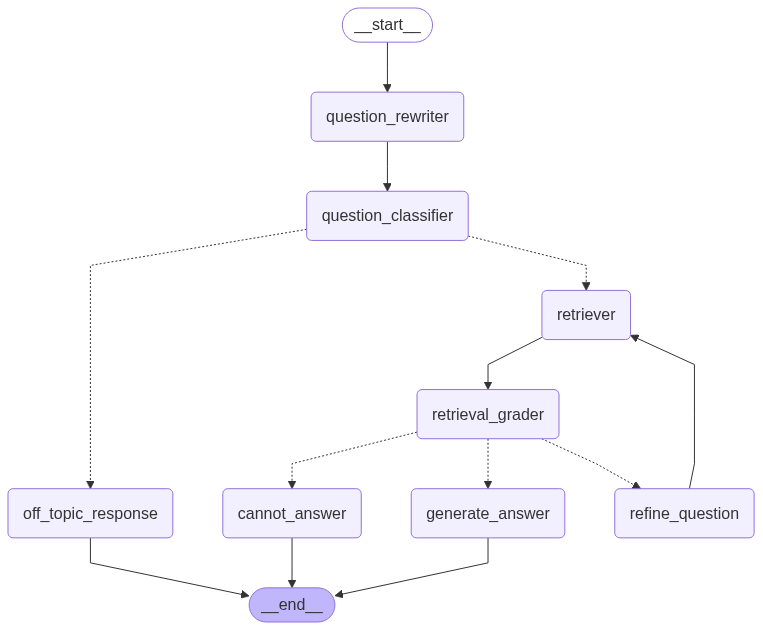

In [227]:
from IPython.display import Image,display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [228]:
thread_config = {
    "configurable":{"thread_id":1}
}
graph.invoke({"question":HumanMessage(content="what are timings for nexatech solutions software development department?")},config=thread_config)

Question rewriter rephrased question: what are timings for nexatech solutions software development department?

Enter question classifier
Entering off topic edge val:yes
proceed to next generate after retrieval grader , val: True
Entering to proceed router
Routing to generate answer
Final answer: content='The NexaTech Solutions Software Development Department operates from Monday to Friday, 9:00 AM - 6:00 PM. On-call support is available 24/7.' additional_kwargs={} response_metadata={}


{'messages': [HumanMessage(content='what are timings for nexatech solutions software development department?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='The NexaTech Solutions Software Development Department operates from Monday to Friday, 9:00 AM - 6:00 PM. On-call support is available 24/7.', additional_kwargs={}, response_metadata={})],
 'documents': [Document(metadata={'source': 'nexatech/company_overview', 'department': 'administration', 'last_updated': '2024-01-15'}, page_content=' \nNexaTech Solutions is a leading technology consulting and software development company founded in 2018.\nWe specialize in enterprise software solutions, cloud infrastructure, and digital transformation services.\nOur headquarters is located in Austin, Texas, with additional offices in Denver, Seattle, and Miami.\nThe company employs over 250 skilled professionals including software engineers, data scientists, and project managers.\nWe serve clients across healthcare, finance, 

In [229]:
graph.invoke({"question":HumanMessage("and what about Human Resources Department?")},config=thread_config)

Question rewriter rephrased question: What are the timings for the NexaTech Solutions Human Resources Department?

Enter question classifier
Entering off topic edge val:yes
proceed to next generate after retrieval grader , val: True
Entering to proceed router
Routing to generate answer
Final answer: content='The NexaTech Solutions Human Resources Department has the following timings:\n*   **HR Office Hours:** Monday - Friday, 8:00 AM - 5:00 PM (Central Time)\n*   **Recruitment Hours:** Monday - Thursday, 9:00 AM - 4:00 PM' additional_kwargs={} response_metadata={}


{'messages': [HumanMessage(content='what are timings for nexatech solutions software development department?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='The NexaTech Solutions Software Development Department operates from Monday to Friday, 9:00 AM - 6:00 PM. On-call support is available 24/7.', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='and what about Human Resources Department?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='The NexaTech Solutions Human Resources Department has the following timings:\n*   **HR Office Hours:** Monday - Friday, 8:00 AM - 5:00 PM (Central Time)\n*   **Recruitment Hours:** Monday - Thursday, 9:00 AM - 4:00 PM', additional_kwargs={}, response_metadata={})],
 'documents': [Document(metadata={'source': 'nexatech/human_resources', 'last_updated': '2024-01-13', 'department': 'hr'}, page_content='\nNexaTech Solutions Human Resources Department manages talent acquisition, employee development,